In [21]:
# ===================================================================
# Protein-Infer: 02_Model_Training.ipynb (Corrected Full Version)
# ===================================================================

# Step 1: Install and import necessary libraries
# The '-q' flag makes the output less noisy (quiet)
!pip install transformers torch scikit-learn pandas tqdm -q

import pandas as pd
import numpy as np
import torch
import pickle
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModel

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# --- Configuration ---
DATA_PATH = '/content/drive/MyDrive/Protein-Infer/data/train.csv'
MODEL_PATH = '/content/drive/MyDrive/Protein-Infer/models/' # Directory to save the trained model files

In [24]:
# Using a smaller sample for faster development.
# DATA_SAMPLE_SIZE = 2000
PLM_MODEL_NAME = "Rostlab/prot_bert"
MAX_LENGTH = 512 # Max sequence length for ProtBERT's tokenizer


In [25]:
# --- Step 2: Load and Prepare the Dataset (with Multi-Label Fix) ---
print("➡️ Step 2: Loading and preparing the dataset...")
df = pd.read_csv(DATA_PATH)
# if DATA_SAMPLE_SIZE:
   # df = df.sample(n=DATA_SAMPLE_SIZE, random_state=42)
print(f"✅ Dataset loaded successfully with {len(df)} samples.")

➡️ Step 2: Loading and preparing the dataset...
✅ Dataset loaded successfully with 28303 samples.


In [26]:
# Identify all the columns that represent a subcellular location
label_columns = [
    'Membrane', 'Cytoplasm', 'Nucleus', 'Extracellular', 'Cell membrane',
    'Mitochondrion', 'Plastid', 'Endoplasmic reticulum', 'Lysosome/Vacuole',
    'Golgi apparatus', 'Peroxisome'
]

In [27]:
# This function converts the multi-label format to a single label
# by finding the first location marked as '1.0' in the row.
def get_first_location(row):
    for col in label_columns:
        if row[col] == 1.0:
            return col
    return 'Unknown'

print("➡️ Converting multi-label data to a single 'Location' column...")
df['Location'] = df.apply(get_first_location, axis=1)

# We only keep rows where a valid location was found
df_filtered = df[df['Location'] != 'Unknown'].copy()

print("✅ Data conversion complete. The new 'Location' column is ready.")
print("\nValue counts for the new 'Location' column:")
print(df_filtered['Location'].value_counts())

➡️ Converting multi-label data to a single 'Location' column...
✅ Data conversion complete. The new 'Location' column is ready.

Value counts for the new 'Location' column:
Location
Membrane                 8593
Cytoplasm                8492
Nucleus                  5407
Extracellular            2897
Mitochondrion            1371
Plastid                   651
Endoplasmic reticulum     334
Lysosome/Vacuole          246
Peroxisome                159
Golgi apparatus           126
Cell membrane              27
Name: count, dtype: int64


In [28]:
# --- Step 3: Load the Protein Language Model (ProtBERT) ---
print(f"\n➡️ Step 3: Loading the Protein Language Model ({PLM_MODEL_NAME})...")
tokenizer = AutoTokenizer.from_pretrained(PLM_MODEL_NAME)
model = AutoModel.from_pretrained(PLM_MODEL_NAME)


➡️ Step 3: Loading the Protein Language Model (Rostlab/prot_bert)...


In [29]:
# Use GPU if available for a significant speed-up
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"✅ Model loaded and moved to {device}.")

✅ Model loaded and moved to cuda.


In [30]:
# --- Step 4: Generate Embeddings ---
print("\n➡️ Step 4: Generating protein embeddings. This is the most time-consuming step.")

def get_embedding(sequence):
    """Converts a protein sequence into a numerical embedding."""
    sequence_spaced = " ".join(list(sequence))
    inputs = tokenizer(
        sequence_spaced,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

# Apply the function to all sequences with a progress bar
tqdm.pandas(desc="Generating Embeddings")
df_filtered['embedding'] = df_filtered['Sequence'].progress_apply(get_embedding)
print("✅ Embeddings generated for all sequences.")


➡️ Step 4: Generating protein embeddings. This is the most time-consuming step.


Generating Embeddings:   0%|          | 0/28303 [00:00<?, ?it/s]

✅ Embeddings generated for all sequences.


In [37]:
# --- Step 5: Train the Classifier ---
print("\n➡️ Step 5: Preparing data and training the classifier...")

# Filter out classes with only one sample
class_counts = df_filtered['Location'].value_counts()
classes_to_keep = class_counts[class_counts >= 2].index
df_filtered_cleaned = df_filtered[df_filtered['Location'].isin(classes_to_keep)].copy()

X = np.vstack(df_filtered_cleaned['embedding'].values)
y = df_filtered_cleaned['Location'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
classifier.fit(X_train, y_train)
print("✅ Classifier training complete.")


➡️ Step 5: Preparing data and training the classifier...
✅ Classifier training complete.


In [38]:
# --- Step 6: Save the Model and Labels ---
print("\n➡️ Step 6: Saving the trained model and class labels...")

# Create the models directory if it doesn't exist
import os
os.makedirs(MODEL_PATH, exist_ok=True)

# Save the trained classifier object
with open(f'{MODEL_PATH}protein_classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)

# Save the unique class labels from the cleaned data
class_labels = sorted(list(df_filtered_cleaned['Location'].unique()))
with open(f'{MODEL_PATH}class_labels.pkl', 'wb') as f:
    pickle.dump(class_labels, f)

print(f"\n🚀 Phase 2 Complete! Model saved to '{MODEL_PATH}protein_classifier.pkl' and labels to '{MODEL_PATH}class_labels.pkl'.")


➡️ Step 6: Saving the trained model and class labels...

🚀 Phase 2 Complete! Model saved to '/content/drive/MyDrive/Protein-Infer/models/protein_classifier.pkl' and labels to '/content/drive/MyDrive/Protein-Infer/models/class_labels.pkl'.


In [39]:
# ===================================================================
# Protein-Infer: Phase 3 - Model Evaluation & Analysis
# ===================================================================

In [40]:
# Step 1: Import necessary libraries for evaluation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

print("✅ Evaluation libraries imported.")

✅ Evaluation libraries imported.


In [41]:
# --- Step 2: Make Predictions on the Test Data ---
print("\n➡️ Step 2: Making predictions on the unseen test set...")
# The 'classifier' is already trained and 'X_test' is ready from the previous steps
y_pred = classifier.predict(X_test)
print("✅ Predictions made.")


➡️ Step 2: Making predictions on the unseen test set...
✅ Predictions made.


In [44]:
# --- Step 3: Generate and Print Evaluation Metrics ---
print("\n➡️ Step 3: Generating evaluation metrics...")

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Overall Model Accuracy ---")
print(f"Accuracy: {accuracy:.4f}")

# Generate a detailed classification report
# 'target_names' makes the report human-readable
report = classification_report(y_test, y_pred, target_names=class_labels)
print("\n--- Detailed Classification Report ---")
print(report)


➡️ Step 3: Generating evaluation metrics...

--- Overall Model Accuracy ---
Accuracy: 0.6564

--- Detailed Classification Report ---
                       precision    recall  f1-score   support

        Cell membrane       0.00      0.00      0.00         5
            Cytoplasm       0.54      0.77      0.64      1699
Endoplasmic reticulum       0.85      0.16      0.28        67
        Extracellular       0.89      0.78      0.83       579
      Golgi apparatus       0.00      0.00      0.00        25
     Lysosome/Vacuole       0.75      0.06      0.11        49
             Membrane       0.71      0.76      0.73      1719
        Mitochondrion       0.85      0.22      0.35       274
              Nucleus       0.69      0.47      0.56      1082
           Peroxisome       1.00      0.19      0.32        32
              Plastid       0.83      0.50      0.62       130

             accuracy                           0.66      5661
            macro avg       0.65      0.36   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



➡️ Step 4: Generating the confusion matrix visualization...


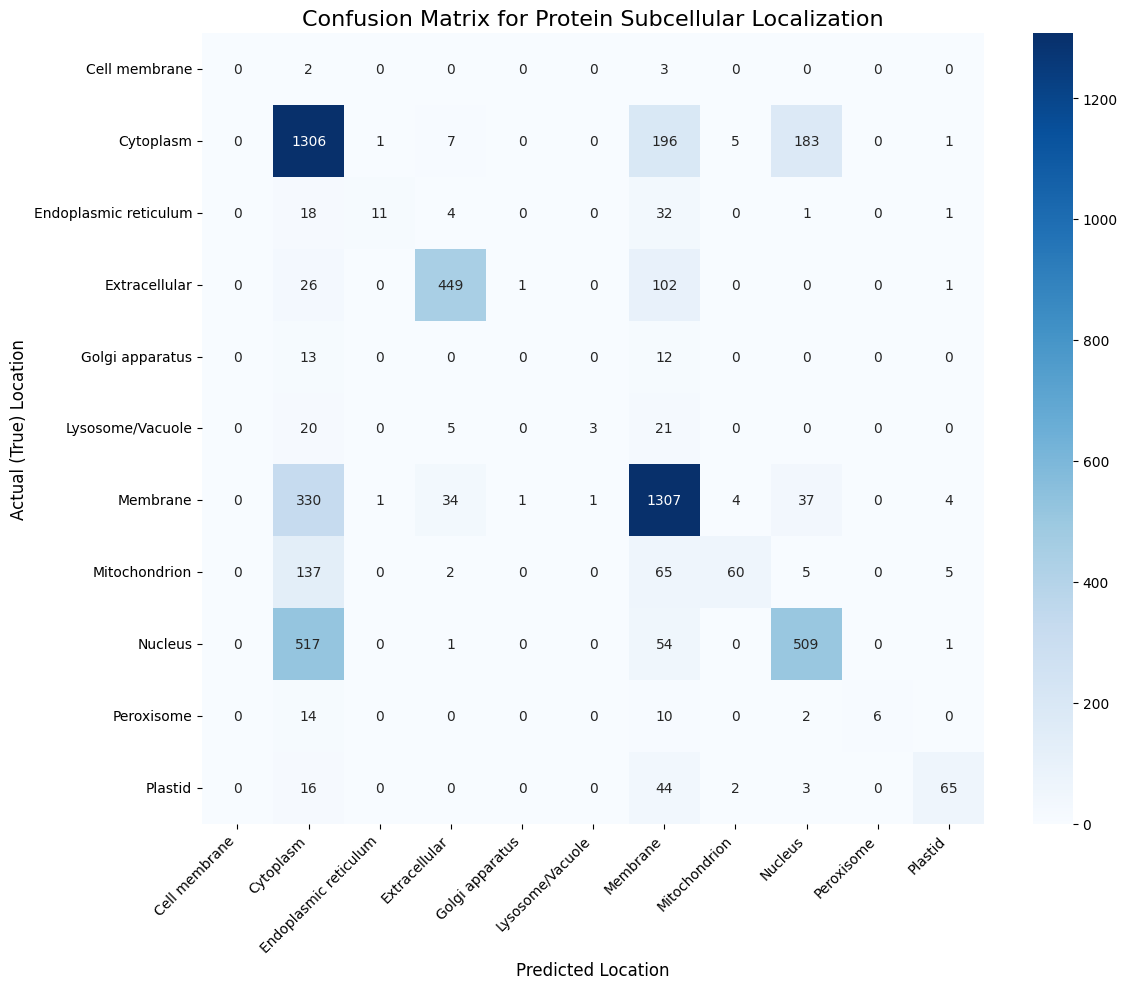


🚀 Phase 3 Complete! You have a full evaluation of your model's performance.


In [45]:
# --- Step 4: Visualize the Confusion Matrix ---
print("\n➡️ Step 4: Generating the confusion matrix visualization...")

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot the heatmap for a clear visual representation
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Protein Subcellular Localization', fontsize=16)
plt.ylabel('Actual (True) Location', fontsize=12)
plt.xlabel('Predicted Location', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to make room for labels
plt.show()

print("\n🚀 Phase 3 Complete! You have a full evaluation of your model's performance.")